<a href="https://colab.research.google.com/github/supsi-dacd-isaac/TeachDecisionMakingUncertainty/blob/main/L11/Value_and_Policy_iterations_solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Value and policy iterations
An agent is in the bottom left cell of a grid. The grey cell is a wall. The two coloured cells give a reward. There is a reward of 1 of being in the top-right (green) cell, but a negative value of -1 for the cell immediately below (red).
<div>
<img src="https://gibberblot.github.io/rl-notes/_images/9322df0c1c9c3378ee27b457ed43bad878f17fd29ae92fd027efe05f7c835593.png" width="300"/>
</div>

* If the agent tries to move north, 80%
 of the time, this works as planned (provided the wall is not in the way)
* 10% of the time, trying to move north takes the agent west (provided the wall is not in the way);

* 10% of the time, trying to move north takes the agent east (provided the wall is not in the way)

* If the wall is in the way of the cell that would have been taken, the agent stays in the current cell.

The task is to navigate from the start cell in the bottom left to maximise the expected reward. What would the best sequence of actions be for this problem?

We will try to solve this using policy iteration and value iteration!

In [1]:
%%capture
from collections import defaultdict
import json
import random
!wget https://github.com/supsi-dacd-isaac/TeachDecisionMakingUncertainty/raw/refs/heads/main/L11/mdp.py
!wget https://github.com/supsi-dacd-isaac/TeachDecisionMakingUncertainty/raw/refs/heads/main/L11/gridworld.py
!wget https://github.com/supsi-dacd-isaac/TeachDecisionMakingUncertainty/raw/refs/heads/main/L11/rendering_utils.py
from gridworld import GridWorld


In [2]:

class TabularPolicy:
    def __init__(self, default_action=None):
        self.policy_table = defaultdict(lambda: default_action)

    def select_action(self, state, actions):
        return self.policy_table[state]

    def update(self, state, action):
        self.policy_table[state] = action

class QFunction:

    """ Return the action with the maximum Q-value """
    def get_argmax_q(self, state, actions):
        (argmax_q, max_q) = self.get_max_pair(state, actions)
        return argmax_q

    """ Return the maximum Q-value in this Q-function """
    def get_max_q(self, state, actions):
        (argmax_q, max_q) = self.get_max_pair(state, actions)
        return max_q

    """ Return a pair containing the action and Q-value, where the
        action has the maximum Q-value in state
    """
    def get_max_pair(self, state, actions):
        max_q = float("-inf")
        max_actions = []
        for action in actions:
            value = self.get_q_value(state, action)
            if value > max_q:
                max_actions = [action]
                max_q = value
            elif value == max_q:
                max_actions += [action]

        arg_max_q = random.choice(max_actions)
        return (arg_max_q, max_q)


class QTable(QFunction):
    def __init__(self, alpha=0.1, default_q_value=0.0):
        self.qtable = defaultdict(lambda: default_q_value)
        self.alpha = alpha

    def update(self, state, action, delta):
        self.qtable[(state, action)] = self.qtable[(state, action)] + self.alpha * delta

    def get_q_value(self, state, action):
        return self.qtable[(state, action)]

    def get_q_values(self, states, actions):
        return [self.get_q_value(state, action) for state, action in zip(states, actions)]

    def save(self, filename):
        with open(filename, "w") as file:
            serialised = {str(key): value for key, value in self.qtable.items()}
            json.dump(serialised, file)

    def load(self, filename, default=0.0):
        with open(filename, "r") as file:
            serialised = json.load(file)
            self.qtable = defaultdict(
                lambda: default,
                {tuple(eval(key)): value for key, value in serialised.items()},
            )

class ValueFunction():

    """ Return the Q-value of action in state """
    def get_q_value(self, mdp, state, action):
        q_value = 0.0
        for (new_state, probability) in mdp.get_transitions(state, action):
            reward = mdp.get_reward(state, action, new_state)
            q_value +=  (
                reward
                + probability *(mdp.get_discount_factor() * self.get_value(new_state))
            )

        return q_value

    """ Return a policy from this value function """

    def extract_policy(self, mdp):
        policy = TabularPolicy()
        for state in mdp.get_states():
            max_q = float("-inf")
            for action in mdp.get_actions(state):
                q_value = self.get_q_value(mdp, state, action)

                # If this is the maximum Q-value so far,
                # set the policy for this state
                if q_value > max_q:
                    policy.update(state, action)
                    max_q = q_value

        return policy

In [3]:

class TabularValueFunction(ValueFunction):
    def __init__(self, alpha=0.1, default=0.0):
        self.value_table = defaultdict(lambda: default)
        self.alpha = alpha

    def add(self, state, value):
        self.value_table[state] = value

    def update(self, state, delta):
        self.value_table[state] += self.alpha * delta

    def merge(self, value_table):
        for state in value_table.value_table.keys():
            self.add(state, value_table.get_value(state))

    def get_value(self, state):
        return self.value_table[state]

    def get_values(self, states):
        return [self.get_value(state) for state in states]



# Value iteration
Value iteration applies Bellman's update iteratively, and it's guaranteed to converge to the optimal values $\boldsymbol{v}^*$.
$$
\begin{aligned}
&\text{for k in max_iterations}:\\
&\quad v_{k+1}(s)=\underset{a \in A}{ \max }\quad q(s, a)
\end{aligned}
$$

once the values converge to the optimal values, the policy can be extracted with the `ValueFunction`'s `extract_policy` method.

❓ Try to complete the missing part of the following code:

In [4]:

class ValueIteration:
    def __init__(self, mdp, values):
        self.mdp = mdp
        self.values = values

    def value_iteration(self, max_iterations=100, theta=0.001):

        for i in range(max_iterations):
            delta = 0.0
            new_values = TabularValueFunction()
            for state in self.mdp.get_states():
                qtable = QTable(alpha=1.0)
                for action in self.mdp.get_actions(state):
                    # Calculate the value of Q(s,a)
                    new_value = 0.0
                    for (new_state, probability) in self.mdp.get_transitions(
                        state, action
                    ):
                        reward = self.mdp.get_reward(state, action, new_state)
                        ### COMPLETE THIS
                        new_value +=  reward + probability *( self.mdp.get_discount_factor() * self.values.get_value(new_state))

                    qtable.update(state, action, new_value)

                # V(s) = max_a Q(sa)
                max_q = qtable.get_max_q(state, self.mdp.get_actions(state))
                delta = max(delta, abs(self.values.get_value(state) - max_q))
                new_values.add(state, max_q)

            self.values.merge(new_values)

            # Terminate if the value function has converged
            if delta < theta:
                return i


# Policy iteration
We've seen that the policy iteration strategy can be written as:
$$
\begin{aligned}&\text { initialize } \pi \text { (arbitrarily) }\\&\text { repeat until convergence}\\
& \quad \text{ compute } \boldsymbol{v}^{\pi_k}\\
&\quad \text { compute } \pi_{k+1}\end{aligned}
$$

### Compute $v^{\pi_k}$
We've seen that the general Bellman's value iteration update is in the form:
$$v^{\pi_k}(s) \leftarrow \sum_{a \in \mathcal{A}} \pi(a\vert s)\left[r(s, a) + \gamma\sum_{s'} p(s'\vert s, a)v^{\pi}(s')\right]$$
Since the policy in this case is deterministic, the update implemented in `ValueFunction.get_q_value` becomes:
$$v^{\pi_k}(s) \leftarrow r(s, a) + \gamma\sum_{s'} p(s'\vert s, a)v^{\pi}(s')$$

### Compute $\pi_{k+1}$

$$\pi_{k+1}(s) =\underset{a \in A}{\arg \max }\quad r(s, a) + \gamma\sum_{s'} p(s'\vert s, a)v^{\pi_k}(s')$$


❓ Try to complete the missing part of the following code:

In [5]:

class PolicyIteration:
    def __init__(self, mdp, policy):
        self.mdp = mdp
        self.policy = policy

    def policy_evaluation(self, policy, values, theta=0.001):

        while True:
            delta = 0.0
            new_values = TabularValueFunction()
            for state in self.mdp.get_states():
                # Calculate the value of V(s)
                actions = self.mdp.get_actions(state)
                old_value = values.get_value(state)
                new_value = values.get_q_value(
                    self.mdp, state, policy.select_action(state, actions)
                )
                values.add(state, new_value)
                delta = max(delta, abs(old_value - new_value))

            # terminate if the value function has converged
            if delta < theta:
                break

        return values

    """ Implmentation of policy iteration iteration. Returns the number of iterations executed """

    def policy_iteration(self, max_iterations=100, theta=0.001):

        # create a value function to hold details
        values = TabularValueFunction()

        for i in range(1, max_iterations + 1):
            policy_changed = False
            values = self.policy_evaluation(self.policy, values, theta)
            for state in self.mdp.get_states():

                actions = self.mdp.get_actions(state)
                old_action = self.policy.select_action(state, actions)

                q_values = QTable(alpha=1.0)
                for action in self.mdp.get_actions(state):
                    # Calculate the value of Q(s,a)
                    new_value = values.get_q_value(self.mdp, state, action)
                    q_values.update(state, action, new_value)
                # V(s) = argmax_a Q(s,a) ### COMPLETE THIS PART
                new_action = q_values.get_argmax_q(state, self.mdp.get_actions(state))
                self.policy.update(state, new_action)
                policy_changed = (
                    True if new_action is not old_action else policy_changed
                )

            if not policy_changed:
                return i

        return max_iterations


In [6]:
#@title Visualize value iteration

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

gridworld = GridWorld()

fig, ax, img = gridworld.initialise_grid(grid_size=1.0)

images = []

for i in range(14):
    values = TabularValueFunction()
    ValueIteration(gridworld, values).value_iteration(max_iterations=i)

    # Update grid image (background)
    im = ax.imshow(img, origin="lower")

    # Create text annotations
    texts = []
    for y in range(gridworld.height):
        for x in range(gridworld.width):
            if (x, y) not in gridworld.blocked_states:
                value = values.get_value((x, y))
                txt = plt.text(
                    x, y, f"{float(value):+0.2f}",
                    fontsize="medium",
                    ha="center",
                    va="center",
                    color='lightgrey' if value == 0.0 else 'black',
                )
                texts.append(txt)

    # Append both image and text elements to the frame
    images.append([im] + texts)

# Create animation
ani = animation.ArtistAnimation(fig, images, interval=500, blit=True, repeat_delay=1000)
plt.close()
# Display in notebook
HTML(ani.to_jshtml())

In [7]:
#@title Visualize policy iteration
gridworld = GridWorld()
fig, ax, img = gridworld.initialise_grid(grid_size=1.0)

images = []

for i in range(14):
    # Reset value and policy
    values = TabularValueFunction()
    policy = TabularPolicy(default_action=gridworld.LEFT)

    # Run policy iteration up to i iterations
    PolicyIteration(gridworld, policy).policy_iteration(max_iterations=i)

    # Background grid
    im = ax.imshow(img, origin="lower")

    # Visualise policy as arrows
    texts = []
    for y in range(gridworld.height):
        for x in range(gridworld.width):
            state = (x, y)
            if state not in gridworld.blocked_states and state not in gridworld.get_goal_states():
                action = policy.select_action(state, gridworld.get_actions(state))
                if action != gridworld.TERMINATE:
                    arrow_map = {
                        gridworld.UP: '\u2191',
                        gridworld.DOWN: '\u2193',
                        gridworld.LEFT: '\u2190',
                        gridworld.RIGHT: '\u2192',
                    }
                    txt = plt.text(
                        x, y,
                        arrow_map.get(action, 'x'),
                        fontsize="xx-large",
                        ha="center", va="center"
                    )
                    texts.append(txt)
            elif state in gridworld.get_goal_states():
                txt = plt.text(
                    x, y,
                    f"{gridworld.get_goal_states()[state]:+0.2f}",
                    fontsize="x-large",
                    ha="center", va="center",
                )
                texts.append(txt)

    images.append([im] + texts)

# Animate
ani = animation.ArtistAnimation(fig, images, interval=500, blit=True, repeat_delay=1000)

plt.close()
# Display in notebook
HTML(ani.to_jshtml())

# ❓ What's happening in the second bottom cell?
It looks like the policy suggests to go in the wrong direction: a shorter path could be taken if we go right. Can you explain it?
Hint: transition probabilities

In [36]:
#@title Plot transition probabilities
def visualize_transitions(gridworld):
    fig, axes = plt.subplots(2, 2, figsize=(8, 8))
    axes = axes.flatten()

    actions = gridworld.get_actions()

    action_to_arrow = {
        gridworld.UP: (0, 0.4),
        gridworld.DOWN: (0, -0.4),
        gridworld.LEFT: (-0.4, 0),
        gridworld.RIGHT: (0.4, 0),
    }

    for i, action in enumerate(actions):
        if i==0:
          continue
        ax = axes[i-1]
        fig_g, ax_g, im = gridworld.initialise_grid(grid_size=1.0)
        ax.imshow(im, origin='lower', extent=[0, gridworld.width, 0, gridworld.height]);
        plt.close(fig_g)
        ax.set_title(f'Action: {action}')
        ax.set_xticks(range(gridworld.width + 1))
        ax.set_yticks(range(gridworld.height + 1))
        ax.grid(color='gray', linestyle='-', linewidth=1)
        ax.set_xticklabels([])
        ax.set_yticklabels([])

        for y in range(gridworld.height):
            for x in range(gridworld.width):
                state = (x, y)
                if state not in gridworld.blocked_states:
                    transitions = gridworld.get_transitions(state, action)
                    total_prob = sum(prob for _, prob in transitions)

                    # Only draw arrows if there are transitions for this action
                    if total_prob > 0:
                        # Center of the cell
                        center_x, center_y = x + 0.5, y + 0.5

                        for next_state, prob in transitions:
                            if prob > 0:
                                next_x, next_y = next_state
                                dx = (next_x - x) * 0.4 * prob / total_prob  # Scale by probability and ensure direction
                                dy = (next_y - y) * 0.4 * prob / total_prob

                                # Adjust start point slightly for better visualization if multiple transitions
                                # This is a simple approach, might need refinement for complex cases
                                if len(transitions) > 1:
                                     if (dx, dy) == action_to_arrow.get(gridworld.UP):
                                         start_x, start_y = center_x, center_y - 0.1
                                     elif (dx, dy) == action_to_arrow.get(gridworld.DOWN):
                                          start_x, start_y = center_x, center_y + 0.1
                                     elif (dx, dy) == action_to_arrow.get(gridworld.LEFT):
                                         start_x, start_y = center_x + 0.1, center_y
                                     elif (dx, dy) == action_to_arrow.get(gridworld.RIGHT):
                                         start_x, start_y = center_x - 0.1, center_y
                                     else: # Stay in place or diagonal - not strictly part of the prompt but good practice
                                          start_x, start_y = center_x, center_y
                                else:
                                     start_x, start_y = center_x, center_y


                                # Determine arrowhead direction based on state difference
                                if next_x > x:
                                    head_dx = 0.2
                                    head_dy = 0
                                elif next_x < x:
                                    head_dx = -0.2
                                    head_dy = 0
                                elif next_y > y:
                                    head_dx = 0
                                    head_dy = 0.2
                                elif next_y < y:
                                    head_dx = 0
                                    head_dy = -0.2
                                else: # Stay in place
                                    head_dx = 0
                                    head_dy = 0.2 # Represent 'stay' with a small upward arrow from center


                                ax.arrow(start_x, start_y, dx, dy,
                                         head_width=0.15 * prob / total_prob if (dx, dy) != (0,0) else 0, # Scale arrowhead width by probability
                                         head_length=0.2 * prob / total_prob if (dx, dy) != (0,0) else 0, # Scale arrowhead length by probability
                                         fc='blue', ec='blue', length_includes_head=True)

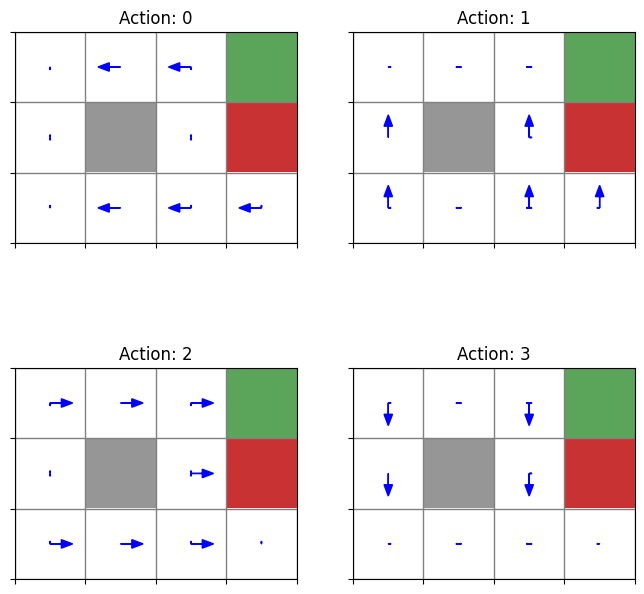

In [37]:
visualize_transitions(GridWorld())

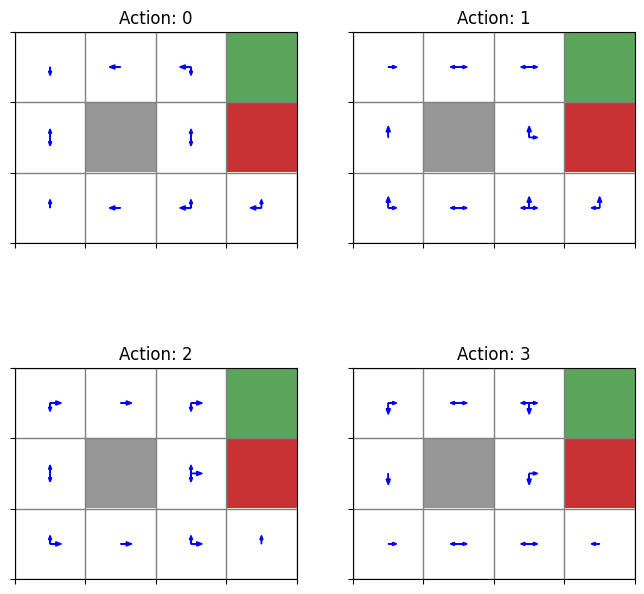

In [38]:
visualize_transitions(GridWorld(noise=0.3));


In [39]:
#@title Visualize policy iteration, noise = 0
gridworld = GridWorld(noise=0)
fig, ax, img = gridworld.initialise_grid(grid_size=1.0)

images = []

for i in range(14):
    # Reset value and policy
    values = TabularValueFunction()
    policy = TabularPolicy(default_action=gridworld.LEFT)

    # Run policy iteration up to i iterations
    PolicyIteration(gridworld, policy).policy_iteration(max_iterations=i)

    # Background grid
    im = ax.imshow(img, origin="lower")

    # Visualise policy as arrows
    texts = []
    for y in range(gridworld.height):
        for x in range(gridworld.width):
            state = (x, y)
            if state not in gridworld.blocked_states and state not in gridworld.get_goal_states():
                action = policy.select_action(state, gridworld.get_actions(state))
                if action != gridworld.TERMINATE:
                    arrow_map = {
                        gridworld.UP: '\u2191',
                        gridworld.DOWN: '\u2193',
                        gridworld.LEFT: '\u2190',
                        gridworld.RIGHT: '\u2192',
                    }
                    txt = plt.text(
                        x, y,
                        arrow_map.get(action, 'x'),
                        fontsize="xx-large",
                        ha="center", va="center"
                    )
                    texts.append(txt)
            elif state in gridworld.get_goal_states():
                txt = plt.text(
                    x, y,
                    f"{gridworld.get_goal_states()[state]:+0.2f}",
                    fontsize="x-large",
                    ha="center", va="center",
                )
                texts.append(txt)

    images.append([im] + texts)

# Animate
ani = animation.ArtistAnimation(fig, images, interval=500, blit=True, repeat_delay=1000)

plt.close()
# Display in notebook
HTML(ani.to_jshtml())